# **Deep learning para diagnóstico anatomopatológico de câncer**

# Introdução

Dentre os diversos tipos de neoplasias, o câncer pulmonar é o maior responsável por mortes, sendo mais de 80% classificados como câncer de pulmão de células não pequenas. A maioria desses inclui o __adenocarcinoma__ e o __carcinoma espinocelular__, também chamado de carcinoma de células escamosas [1].

A classificação precisa de subtipos de câncer pulmonar é de alta complexidade. A caracterização histológica, embora predominante e potencialmente com maior acurácia, apresenta possíveis falhas sendo algumas ligadas à fatores subjetivos, como a experiência do avaliador. Ademais, procedimentos complementares, como testes moleculares, introduzem limitações de aplicabilidade (treinamento e perícia adequados) além de elevados custos [1]. Tais dificuldades ensejam o desenvolvimento de novas técnicas e ferramentas auxiliares no diagnóstico de neoplasias.

Neste projeto, mostraremos como classificar alguns subtipos de câncer de pulmão utilizando redes neurais convolucionais - _convolutional neural networks_ (CNN).

    [1] Chaunzwa, T.L., Hosny, A., Xu, Y. et al. Deep learning classification of lung cancer histology using CT images. Sci Rep 11, 5471 (2021).

## Dataset

O conjunto de dados utilizado foi o *Lung and Colon Cancer Histopathological Image Dataset (LC25000)* [2]:

* **Documentação**: [arXiv:1912.12142](https://arxiv.org/pdf/1912.12142.pdf)
* [**Download**](https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af)

Esse *dataset* contém 25000 imagens coloridas dividas entre 5 classes com 5000 imagens cada. Todas as imagens são de 768 x 768 pixels, no formato .jpeg e podem ser baixadas no endereço indicado abaixo - arquivo LC25000.zip de 1.85 GB. Após extração, a pasta principal *lung_colon_image_set* contém dois subpastas, *colon_image_sets* e *lung_image_sets*. Por simplicidade, trabalharemos diretamente com a última, que contém outras três subpastas secundárias: *lung_aca* com imagens de adenocarcinomas, *lung_scc* com imagens de carcinomas de células escamosas (*squamous cell carcinomas*) e *lung_n* com imagens de tecidos pulmonares benignos.


    [2] Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019. 
Disponível em: [GitHub Repo](https://github.com/tampapath/lung_colon_image_set/blob/master/README.md)

# Análise exploratória

### Carregando dados

In [1]:
import matplotlib.pyplot as plt               # Imagens/gráficos
import torch                                  # PyTorch
from torchvision import datasets, transforms  # PyTorch datasets

data_dir = 'INSERIR_DIRETORIO'
ds = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())

In [2]:
categories = ds.classes # Classes
ds.classes

['lung_aca', 'lung_n', 'lung_scc']

Como mencionado, as três categorias de imagens são:

* **lung_aca**: adenocarcinomas 
* **lung_n**: benigno
* **lung_scc**: carcinoma espinocelular

Abaixo, cada imagem é convertida em um tensor 3 x 768 x 768, sendo 3 = # de canais (rgb) e 768 = # de pixels.

In [3]:
image, label = ds[0]
image

tensor([[[0.8275, 0.8275, 0.8275,  ..., 0.5961, 0.6039, 0.6118],
         [0.8275, 0.8275, 0.8314,  ..., 0.6039, 0.6078, 0.6118],
         [0.8275, 0.8314, 0.8314,  ..., 0.6078, 0.6157, 0.6157],
         ...,
         [0.6667, 0.6706, 0.6745,  ..., 0.6706, 0.6902, 0.7020],
         [0.6510, 0.6549, 0.6588,  ..., 0.6706, 0.6941, 0.7098],
         [0.6431, 0.6431, 0.6510,  ..., 0.6745, 0.6980, 0.7137]],

        [[0.7647, 0.7647, 0.7647,  ..., 0.3294, 0.3373, 0.3451],
         [0.7647, 0.7647, 0.7686,  ..., 0.3373, 0.3412, 0.3451],
         [0.7647, 0.7686, 0.7686,  ..., 0.3412, 0.3373, 0.3373],
         ...,
         [0.4000, 0.4039, 0.4000,  ..., 0.5412, 0.5608, 0.5725],
         [0.3882, 0.3922, 0.3922,  ..., 0.5412, 0.5647, 0.5804],
         [0.3804, 0.3804, 0.3843,  ..., 0.5451, 0.5686, 0.5843]],

        [[0.9412, 0.9412, 0.9412,  ..., 0.8745, 0.8824, 0.8902],
         [0.9412, 0.9412, 0.9451,  ..., 0.8824, 0.8863, 0.8902],
         [0.9412, 0.9451, 0.9451,  ..., 0.8863, 0.8941, 0.

### Amostras

In [4]:
# Função para exibição de um batch

def show_example(image, label):
# Categoria e seu respectivo rótulo
    plt.title(categories[label] + " ("+str(label)+")") 
# .permute pois Matplotlib espera o # de canais na última entrada (768 x 768 x 3)
    plt.imshow(image.permute(1,2,0)) 

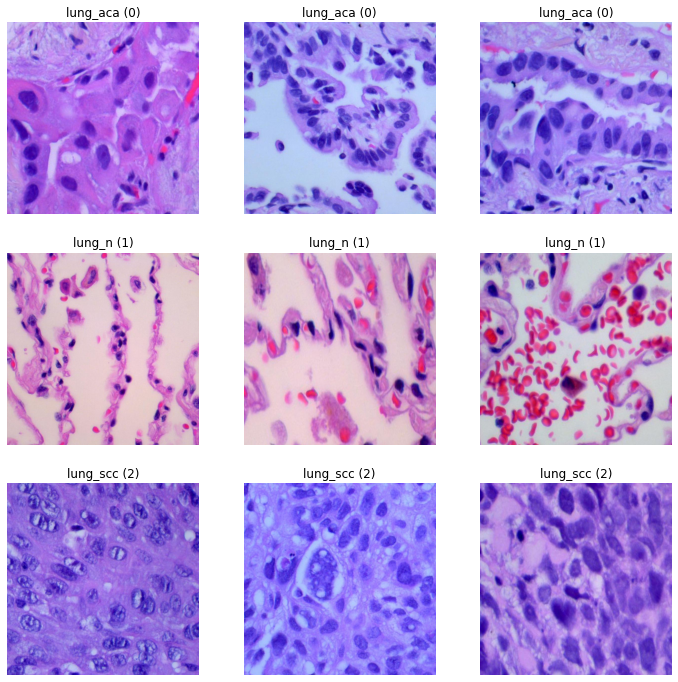

In [5]:
number_of_samples = 3 # Número de amostras mostradas
fig, axs = plt.subplots(number_of_samples, 3, figsize=(12,12))

i=0
# Amostras de imagens
samples = [0, 2500, 4999, 5000, 7500, 9999, 10000, 12500, 14999] 
for img in samples:
    plt.subplot(number_of_samples,3,i+1)
    show_example(*ds[img])
    plt.axis('off')
    i += 1

# Treino

### Pré-processamento de dados

In [6]:
# Separar pastas para treino/validação/teste
import splitfolders                         
# Transformar dados de entrada
import torchvision.transforms as tt         
# Carregar dados para treino/validação/teste
from torch.utils.data import DataLoader     

Dividimos os dados na proporção de (70-15-15)%:
* **Treino**: 10500 imagens
* **Validação**: 2250 imagens
* **Teste**: 2250 imagens

In [7]:
out_dir = 'INSERIR_DIRETORIO_OUT'

splitfolders.ratio(data_dir, 
                   output = out_dir, 
                   seed = 42, 
                   ratio = (0.7,0.15,0.15))

Conforme a documentação em arXiv:1912.12142, o dataset já foi expandido a partir de rotações esquerdas/direitas de até 25 graus 
com probabilidade 1.0 e inversões verticais e horizontais com probabilidade 0.5, de modo que abaixo apenas redimensionamos as imagens para 128 x 128 pixels além de normalizá-las.

In [8]:
# Normalização calculados com a função get_mean_and_std definida adiante
mean_and_std = ((0.6696, 0.5340, 0.8510), (0.0967, 0.1367, 0.0537)) 

# Tamanho da imagem redimensionada
image_size = 128

# Transformações aos dados de treino/validação/teste

train_transformations = tt.Compose([
      tt.Resize(image_size),
      tt.ToTensor(),
      tt.Normalize(*mean_and_std, inplace=True)
])

val_transformations = tt.Compose([
      tt.Resize(image_size),
      tt.ToTensor(),
      tt.Normalize(*mean_and_std, inplace=True)  
])

# Carregando dados num dataset

train_ds = datasets.ImageFolder(out_dir+'/train', train_transformations)
val_ds = datasets.ImageFolder(out_dir+'/val', val_transformations)
test_ds = datasets.ImageFolder(out_dir+'/val', val_transformations)

In [9]:
# Carregamento dos dados de treino/validação
batch_size = 32

train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True,
                          num_workers = 4,
                          pin_memory = True)

val_loader = DataLoader(val_ds,
                        batch_size*2, 
                        num_workers = 4,
                        pin_memory = True)

test_loader = DataLoader(test_ds,
                         batch_size*2,
                         num_workers = 4,
                         pin_memory = True)           

In [10]:
# A função abaixo calcula a média e desvio padrão de cada canal rgb 
# cujos valores foram usados para normaliação dos dados

# def get_mean_and_std(loader):
#     mean = 0.shoul
#     std = 0.
#     total_images_count = 0
#     for images, _ in loader:
#         images_count_in_a_batch = images.size(0)
#         images = images.view(images_count_in_a_batch, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += images_count_in_a_batch
    
#     mean /= total_images_count
#     std /= total_images_count

#     return mean, std

# get_mean_and_std(train_loader) # usando batch_size = 32

### Visualização de um batch

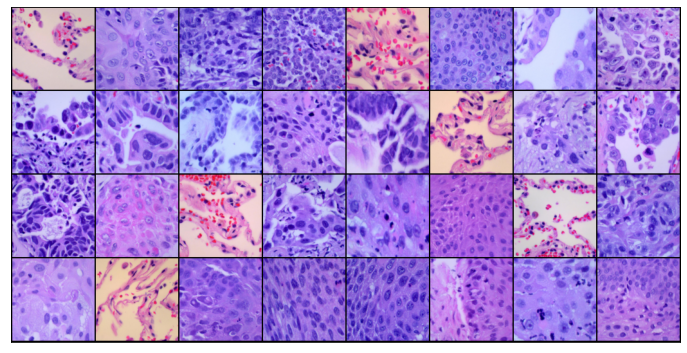

In [11]:
from torchvision.utils import make_grid # Criação de rede

# Remove normalização antes de plotar as imagens
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds + means

def show_batch(loader):
    for images, labels in loader:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *mean_and_std)
        ax.imshow(make_grid(denorm_images, nrow = 8).permute(1,2,0))
        break

# Batch dos dados de treino
show_batch(train_loader)

### Ativando a GPU

In [12]:
# Funções para utilização da GPU

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [13]:
# Move dados para GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(val_loader, device)

# Construção do modelo de CNN

O desenvolvimento da rede neural convolucional a seguir foi baseado em [arXiv: 2009.03878](https://arxiv.org/pdf/2009.03878v1.pdf): _Convolution Neural Networks for diagnosing colon and lung cancer histopathological images_, de onde reproduziu-se a arquitetura e parâmetros. O objetivo foi criar uma _baseline_ para aperfeiçoamentos subsequentes.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# Funções-base para classificação de imagens

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels) 
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, 
            result['train_loss'], 
            result['val_loss'], 
            result['val_acc']
            ))

def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim = 1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds)) 

In [16]:
# Definição da arquitetura

class CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            # Input layer: 3 x 128 x 128
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # Output: 32 x 64 x 64 
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # Output: 64 x 16 x 16
            nn.Flatten(),
            nn.Linear(64*16*16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 3) # 3 = número de categorias
        )

    def forward(self, xb):
        return self.network(xb)

In [17]:
# Definição do treino

@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()  
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
# Modelo + GPU
model = to_device(CNNModel(), device) 
model

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=16384, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.4, inplace=False)
    (13): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [19]:
# Avaliação do modelo pré-treino
evaluate(model, val_loader)

{'val_loss': 1.101482629776001, 'val_acc': 0.2792534828186035}

Como esperado, a acurácia na classificação pré-treino _val_acc_ é $\simeq$ 1/3, ou seja, neste ponto o modelo desempenha como um modelo que escolhe aleatoriamente uma entre as três categorias.

In [20]:
# Parâmetros para treino seguindo
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0001

In [21]:
# Treino
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.3589, val_loss: 0.2105, val_acc: 0.9195
Epoch [1], train_loss: 0.2099, val_loss: 0.2025, val_acc: 0.9219
Epoch [2], train_loss: 0.1679, val_loss: 0.1526, val_acc: 0.9392
Epoch [3], train_loss: 0.1252, val_loss: 0.1009, val_acc: 0.9618
Epoch [4], train_loss: 0.1005, val_loss: 0.0845, val_acc: 0.9688
Epoch [5], train_loss: 0.0722, val_loss: 0.0840, val_acc: 0.9683
Epoch [6], train_loss: 0.0562, val_loss: 0.0777, val_acc: 0.9709
Epoch [7], train_loss: 0.0422, val_loss: 0.0687, val_acc: 0.9701
Epoch [8], train_loss: 0.0417, val_loss: 0.0830, val_acc: 0.9696
Epoch [9], train_loss: 0.0218, val_loss: 0.0731, val_acc: 0.9714
Epoch [10], train_loss: 0.0188, val_loss: 0.1057, val_acc: 0.9692
Epoch [11], train_loss: 0.0170, val_loss: 0.0697, val_acc: 0.9744
Epoch [12], train_loss: 0.0146, val_loss: 0.0817, val_acc: 0.9718
Epoch [13], train_loss: 0.0156, val_loss: 0.0777, val_acc: 0.9688
Epoch [14], train_loss: 0.0162, val_loss: 0.0505, val_acc: 0.9792
Epoch [15], train_lo

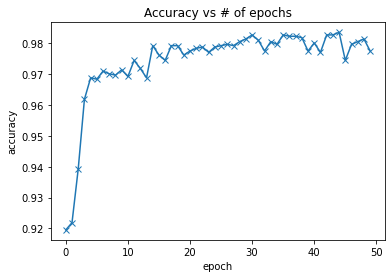

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs # of epochs');

plot_accuracies(history)

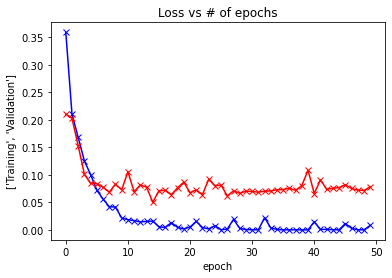

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel(['Training', 'Validation'])
    plt.title('Loss vs # of epochs');

plot_losses(history)

In [24]:
# Função para teste

@torch.no_grad()
def predict_dl(dl, model, threshold=0.5):
    torch.cuda.empty_cache()
    batch_preds = []
    for xb, _ in dl:
        probs = model(xb)
        batch_probs = torch.softmax(probs, dim=1)
        batch_labels = torch.argmax(batch_probs, dim=1)
        batch_preds.append(batch_labels)
    return torch.cat(batch_preds).cpu()

In [25]:
# Teste
test_preds = predict_dl(test_loader, model)
true_label = torch.cat([x for _, x in test_loader]).cpu()

In [26]:
from sklearn.metrics import accuracy_score # Métrica de acurácia

In [27]:
# Acurácia do modelo
accuracy_score(true_label, test_preds)

0.9768888888888889

A acurácia resultante, maior que 97%, reproduz exatamente o resultado obtido em [arXiv: 2009.03878](https://arxiv.org/pdf/2009.03878v1.pdf).

# Próximos passos:

* Validar modelo com outras métricas mais relevantes para o problema, como AUC.
* Testar modelos de arquiteturas: VGG16, ResNet50 etc. 
* Utilizar TPUs ao invés de GPUs ou CPUs, o que pode diminuir significativente o tempo de treino.